<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/dynamic_breakpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic breakpoints

## Review

Humne human-in-the-loop ke motivations discuss kiye:

Approval - Hum apne agent ko interrupt karte hain, uski state user ke saamne dikhate hain, aur user ko action approve karne ka moka dete hain.

Debugging - Hum graph ko rewind karke issues ko reproduce ya unse bacha sakte hain.

Editing - Hum graph ki state ko modify kar sakte hain.

Humne breakpoints ka discussion kiya jo graph ko specific steps par rokne ka ek general tareeqa hai, jo Approval jaise use-cases ko enable karta hai.

Humne yeh bhi dikhaya ke kaise graph state ko edit kiya ja sakta hai aur human feedback introduce kiya ja sakta hai. 😊
## Goals

Breakpoints developer ke zariye kisi specific node par graph compilation ke waqt set kiye jaate hain.

Lekin kabhi-kabhi yeh zaruri hota hai ke graph dynamically apne aap ko interrupt kare!

Is tarah ke internal breakpoints ko NodeInterrupt ka use karke achieve kiya ja sakta hai. 😊
(https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

Dynamic Interruptions kaafi useful hain, aur inke kuch khaas benefits hain:

Conditional Logic:

Graph ko dynamically interrupt karna ek specific condition (developer-defined logic) ke basis par.
User Communication:

Interrupt hone ki wajah user tak convey karna, NodeInterrupt ke zariye custom message pass karke.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langgraph_sdk

In [ ]:
import os
from google.colab import userdata

%env LANGCHAIN_API_KEY = {userdata.get('LANGCHAIN_API_KEY')}
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

env: LANGCHAIN_API_KEY={userdata.get('LANGCHAIN_API_KEY')}


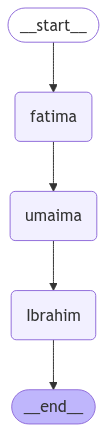

In [ ]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langchain_core.messages import HumanMessage, SystemMessage

class State(TypedDict):
    input: str

def fatima(state: State) -> State:
    print("---Step 1---")
    return state

def umaima(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")

    print("---Step 2---")
    return state

def Ibrahim(state: State) -> State:
    print("---Step 3---")
    return state

builder: StateGraph = StateGraph(State)
builder.add_node("fatima", fatima)
builder.add_node("umaima", umaima)
builder.add_node("Ibrahim", Ibrahim)
builder.add_edge(START, "fatima")
builder.add_edge("fatima", "umaima")
builder.add_edge("umaima", "Ibrahim")
builder.add_edge("Ibrahim", END)

# Set up memory
memory: MemorySaver = MemorySaver()

# Compile the graph with memory
graph: CompiledStateGraph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's run the graph with an input that's longer than 5 characters.

In [ ]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


Agar hum is point par graph state inspect karein, to hume next execute hone wali node (e.g., umaima) ki information milegi.



In [ ]:
state = graph.get_state(thread_config)
print(state.next)

('umaima',)


We can see that the `Interrupt` is logged to state.

In [ ]:
print(state.tasks)

(PregelTask(id='2e34e67e-c258-0a64-4834-ba0226adf558', name='umaima', path=('__pregel_pull', 'umaima'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None, when='during'),), state=None, result=None),)


Agar hum graph ko breakpoint se resume karte hain, to yeh wahi same node dobara run karega.

Agar state change na ki gayi ho, to graph usi node par stuck rahega.

In [ ]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [ ]:
state = graph.get_state(thread_config)
print(state.next)

('umaima',)


Now, we can update state.

In [ ]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efca856-a025-616a-800e-4b78e7b9d6f7'}}

In [ ]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


### Usage with LangGraph API

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

*Also, if you are running this notebook in CoLab, then skip this step.*

--

We can run the above graph in Studio with `module-3/studio/dynamic_breakpoints.py`.

![Screenshot 2024-08-27 at 2.02.20 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaedf43c3d4df239c589e_dynamic-breakpoints1.png)

In [ ]:
import platform

if 'google.colab' in str(get_ipython()) or platform.system() != 'Darwin':
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab or requires a Mac")

We connect to it via the SDK.

In [ ]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "https://cardiff-rivers-timothy-supply.trycloudflare.com"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [ ]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):

    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef7bea5-52e3-64f2-b9c2-9c4247af6f1b', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}





In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])

In [ ]:
current_state['next']

['step_2']

In [ ]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'checkpoint': {'thread_id': 'a394a61a-ec3a-4769-8d53-617414ed175f',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7bea6-a84b-6ec4-8002-738a0528c65e'},
 'configurable': {'thread_id': 'a394a61a-ec3a-4769-8d53-617414ed175f',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7bea6-a84b-6ec4-8002-738a0528c65e'},
 'checkpoint_id': '1ef7bea6-a84b-6ec4-8002-738a0528c65e'}

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):

    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef7bea7-08b9-6d5f-b509-1391f5ab13a0', 'attempt': 1}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [ ]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'step': 4,
  'run_id': '1ef7bea7-08b9-6d5f-b509-1391f5ab13a0',
  'source': 'loop',
  'writes': {'step_3': {'input': 'hi!'}},
  'parents': {},
  'user_id': '',
  'graph_id': 'dynamic_breakpoints',
  'thread_id': 'a394a61a-ec3a-4769-8d53-617414ed175f',
  'created_by': 'system',
  'run_attempt': 1,
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'x-forwarded-for': '34.48.111.248',
  'x-forwarded-proto': 'https'},
 'created_at': '2024-09-26T09:33:51.352382+00:00',
 'checkpoint': {'thread_id': 'a394a61a-ec3a-4769-8d53-617414ed175f',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7bea7-09aa-6f3c-8004-0d63c32e8a69'},
 'parent_checkpoint': {'thread_id': 'a394a61a-ec3a-4769-8d53-617414ed175f',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7bea7-099d-621f-8003-de7c4b415319'},
 'checkpoint_id': '1ef7bea7-09aa-6f3c-8004-0d63c32e8a69',
 'parent_checkpoint_id': '1ef7bea7-099d-621f-8003-de7c4b415319'}